In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

In [3]:
n_samples = 2000

def get_dataset_1(N=3):
    centers = []
    for i in range(N):
        for j in range(N):
            centers.append([i, j])
#    centers = [(-5, -5), (0, 0), (5, 5), (-5, 5), (5, -5), (0, 5), (5, 0), (-5, 0), (0, -5)]
#     centers = [(-5, -5), (0, 0), (5, 5)]
    # centers = [(-5, -5), (5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, cluster_std=0.2, 
                  random_state=42)
    X = (X - X.mean())/X.std()
    return X, y

In [4]:
X, y = get_dataset_1()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

9


Text(0.5, 1.0, 'Data')

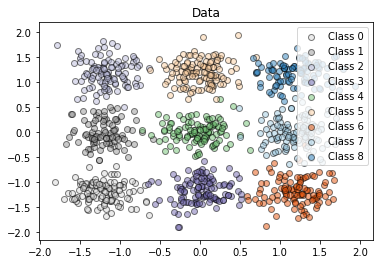

In [6]:
plt.figure()
y_unique = np.unique(y)
print(y_unique.size)
colors = cm.tab20c_r(np.linspace(0.0, 1.0, y_unique.size))
# np.random.shuffle(colors)
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

In [7]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, input_dim=2, compile_model_flag=True, lr=0.001, activation='tanh', kernel_initializer=initializers.glorot_uniform(), 
              reduce = 0.2,  output_size = 3):
    # Creo el modelo
    inp = Input(shape=(input_dim,))
    #bias_initializer = initializers.RandomUniform(-0.1, 0.1)
    bias_initializer = initializers.glorot_uniform()
    #bias_initializer = initializers.zeros()
    first_layer_out = Dense(784//reduce, activation=activation, name='hidden_1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(input_dim,))(inp)
    second_layer_out = Dense(784//reduce, activation=activation, name='hidden_2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(first_layer_out)
    output = Dense(output_size, name='Salida', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, activation='softmax')(second_layer_out)
    model = Model(inp, output)
    model_multiple_out = Model(inp, [first_layer_out, second_layer_out, output])
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model, model_multiple_out

model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.summary()

Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 3919)              11757     
_________________________________________________________________
hidden_2 (Dense)             (None, 3919)              15362480  
_________________________________________________________________
Salida (Dense)               (None, 9)                 35280     
Total params: 15,409,517
Trainable params: 15,409,517
Non-trainable params: 0
_________________________________________________________________


In [9]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'
model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.save_weights(initial_weights)
epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/5
32/32 [==============================] - 1s 24ms/step - loss: 0.4468 - accuracy: 0.8260 - val_loss: 0.1370 - val_accuracy: 0.9490
Epoch 2/5
32/32 [==============================] - 3s 87ms/step - loss: 0.1582 - accuracy: 0.9430 - val_loss: 0.0987 - val_accuracy: 0.9630
Epoch 3/5
32/32 [==============================] - 0s 5ms/step - loss: 0.1545 - accuracy: 0.9430 - val_loss: 0.1492 - val_accuracy: 0.9530
Epoch 4/5
32/32 [==============================] - 2s 53ms/step - loss: 0.2091 - accuracy: 0.9280 - val_loss: 0.0888 - val_accuracy: 0.9680
Epoch 5/5
32/32 [==============================] - 0s 6ms/step - loss: 0.2066 - accuracy: 0.9380 - val_loss: 0.0954 - val_accuracy: 0.9720


In [10]:
from LTH_helper import plot_binary_multiclass_model

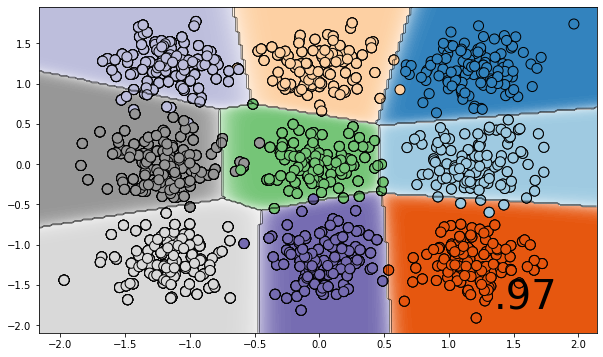

In [11]:
plt.figure(figsize=(10, 6))
plot_binary_multiclass_model(model, X_test, y_test, colors=colors)

In [12]:
from LTH_helper import prune_and_initilize, plot_MC_boundaries_keras, prune_delta_weights, get_model_sparcity

In [13]:
pms = np.linspace(0.0001, 0.9999, 50)
accs = []
model.load_weights(best_weights)
for i, pm in enumerate(pms):
    pruned_model = prune_and_initilize(model, pm, initial_weights)
    acc = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
    accs.append(acc)
    print(i, pm, acc)

Instructions for updating:
Please use `layer.add_weight` method instead.
0 0.0001 0.10400000214576721
1 0.020504081632653062 0.10400000214576721
2 0.04090816326530613 0.11100000143051147
3 0.061312244897959195 0.11100000143051147
4 0.08171632653061225 0.11100000143051147
5 0.10212040816326531 0.11100000143051147
6 0.12252448979591839 0.1120000034570694
7 0.14292857142857143 0.125
8 0.1633326530612245 0.17800000309944153
9 0.18373673469387755 0.2840000092983246
10 0.2041408163265306 0.4059999883174896
11 0.22454489795918367 0.5
12 0.24494897959183676 0.5720000267028809
13 0.2653530612244898 0.6269999742507935
14 0.2857571428571429 0.6800000071525574
15 0.30616122448979594 0.7319999933242798
16 0.326565306122449 0.7559999823570251
17 0.34696938775510205 0.7919999957084656
18 0.3673734693877551 0.8140000104904175
19 0.3877775510204082 0.8309999704360962
20 0.40818163265306123 0.8489999771118164
21 0.4285857142857143 0.8669999837875366
22 0.44898979591836735 0.8840000033378601
23 0.4693938

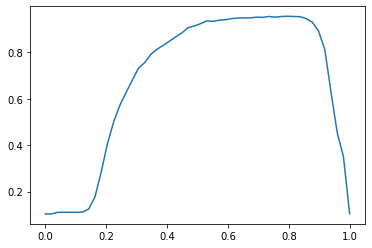

In [14]:
plt.plot(pms, accs)

In [15]:
model.load_weights(initial_weights)
model.evaluate(X_test, y_test, verbose=0)[1]

0.10400000214576721

0.7958591836734694 0.9559999704360962
32/32 [==============================] - 0s 2ms/step - loss: 0.5330 - accuracy: 0.9560
0.9559999704360962


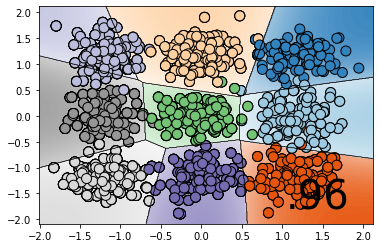

In [16]:
best = np.argmax(accs)
print(pms[best], accs[best])
model.load_weights(best_weights)
pruned_model = prune_and_initilize(model, pms[best], initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

32/32 [==============================] - 0s 2ms/step - loss: 1.3276 - accuracy: 0.3740
0.37400001287460327


/home/usuario/repos/prunning-fashion-MNIST/LTH_helper.py:277: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z_selected, (thres,), colors='k', linewidths=0.5)


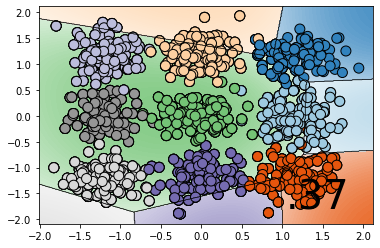

In [17]:
pruned_model = prune_and_initilize(model, 0.2, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

32/32 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.9560
0.9559999704360962


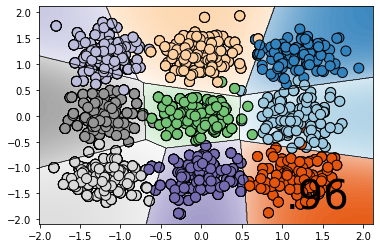

In [18]:
pruned_model = prune_and_initilize(model, 0.8, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=1-1/9)

# Delta weights

In [19]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'

In [20]:
# get_model_sparcity(model_delta)

In [21]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0888 - accuracy: 0.9680


[0.08882317692041397, 0.9679999947547913]

In [22]:
model, _ = get_model(input_dim=2, output_size=len(y_unique))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1), metrics=['accuracy'])
model_delta_untrained, model_delta_trained, model_untrained = prune_delta_weights(model, X_train, y_train, epochs=2)

model_delta_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_untrained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model_delta_trained.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

Epoch 1/2
32/32 [==============================] - 0s 2ms/step - loss: 1.1987 - accuracy: 0.7170
Epoch 2/2
32/32 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.9100


[0.42092978954315186, 0.9100000262260437]

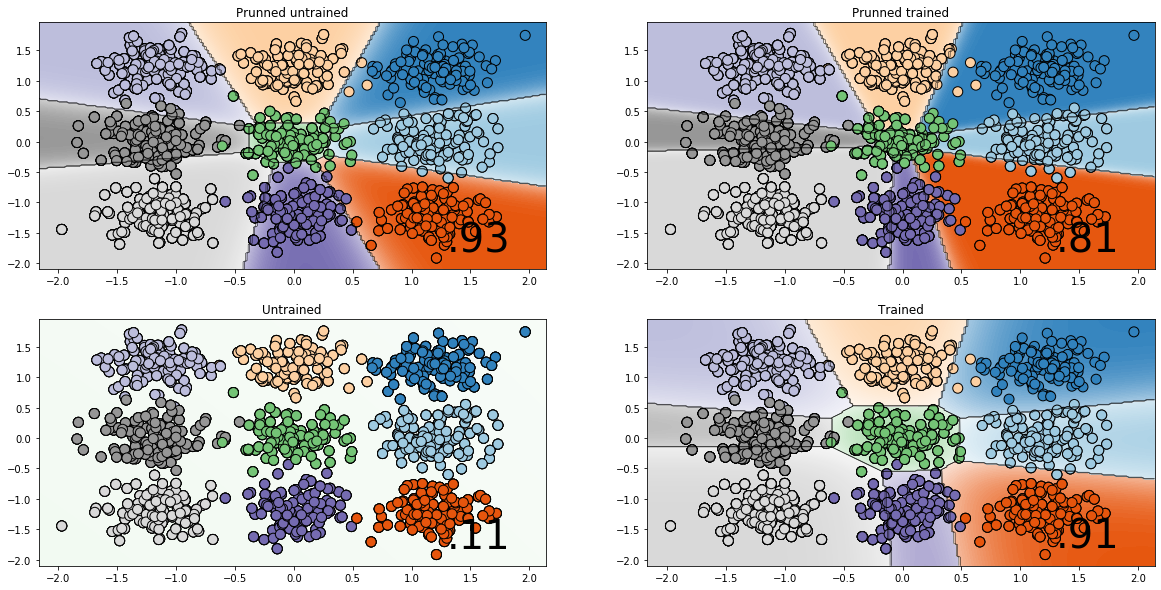

In [23]:
f, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.reshape(-1)
axs[0].set_title('Prunned untrained')
plot_binary_multiclass_model(model_delta_untrained, X_test, y_test, ax=axs[0], colors=colors)
axs[1].set_title('Prunned trained')
plot_binary_multiclass_model(model_delta_trained, X_test, y_test, ax=axs[1], colors=colors)
axs[2].set_title('Untrained')
plot_binary_multiclass_model(model_untrained, X_test, y_test, ax=axs[2], colors=colors)
axs[3].set_title('Trained')
plot_binary_multiclass_model(model, X_test, y_test, ax=axs[3], colors=colors)


In [24]:
get_model_sparcity(model_delta_untrained)

input_56: 

hidden_1: 
0.233222760908395 7838
0.3978055626435315 3919

hidden_2: 
0.49371552452081935 15358561
0.44526664965552437 3919

Salida: 
0.36310283235519264 35271
0.4444444444444444 9

Network sparcity:
0.4932473224176981


In [30]:
model_untrained.save_weights('untrained.hdf5')
pruned_model_48 = prune_and_initilize(model, 1-0.4932, 'untrained.hdf5')

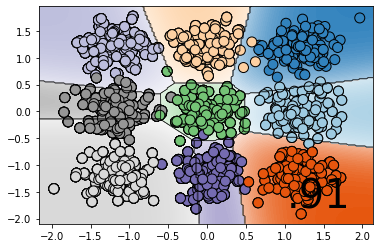

In [32]:
plt.figure()
plot_binary_multiclass_model(model, X_test, y_test, colors=colors)

In [27]:
get_model_sparcity(pruned_model_48)

prune_low_magnitude_hidden_1: 
0.4826486348558306 7838
0.0 3919

prune_low_magnitude_hidden_2: 
0.48269977897017824 15358561
0.0 3919

prune_low_magnitude_Salida: 
0.4826911627115761 35271
0.0 9

Network sparcity:
0.4824539276604192


In [28]:
get_model_sparcity(model_delta_untrained)

input_56: 

hidden_1: 
0.233222760908395 7838
0.3978055626435315 3919

hidden_2: 
0.49371552452081935 15358561
0.44526664965552437 3919

Salida: 
0.36310283235519264 35271
0.4444444444444444 9

Network sparcity:
0.4932473224176981


In [29]:
get_model_sparcity(model_delta_trained)

input_56: 

hidden_1: 
0.233222760908395 7838
0.3978055626435315 3919

hidden_2: 
0.4937153291900198 15358561
0.44526664965552437 3919

Salida: 
0.36310283235519264 35271
0.4444444444444444 9

Network sparcity:
0.49324712773281604
